# Sepsis Prediction, Code Example  
__Author__: Katrina Adams  
__Data__: Publicly avaialable from 2019 CINC sepsis prediction challenge  
__Objective__: Predict Sepsis from time series of measurements 4 hours ahead  
  
I chose this use case and began a notebook in preparation for a 3-hour take-home data science exercise as part of the interview process for a  healthcare ML company. I started this work before receiving the take-home and it does not contain any data or information from that interview process. 

This notebook is an extension of that work to show how I typically organize my code and the rough process that I might go through for an initial experiement on a new data set and use case. I'll show a very light EDA and look at two sets of features with a couple of models and how they perform on a single prediction task. This notebook is not meant to be exhaustive (with notes on everything that I might consider or try for a similar problem), and as we'll see, the models aren't great at the prediction task, but that's OK because this notebook is primarily intended to be a code sample.

In [1]:
import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join
from time import time
from IPython.display import display, Markdown
from IPython.core.display import display, HTML
from importlib import reload
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
import sklearn
from sklearn.metrics import accuracy_score, log_loss, balanced_accuracy_score, average_precision_score, recall_score, f1_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer


In [2]:
import Helpers
reload(Helpers)
from Helpers import (get_target_ahead, train_test_split, plot_facets, plot_correlation_heatmap, 
                     filter_rows, impute_carryforward_group_simple, show_model_scores, add_hist_features,
                     MyLogisticRegression, MyXGBClassifier)


In [3]:
df = pd.read_csv('sepsis_training_data.csv')

In [64]:
display(Markdown('This dataframe has __{} columns__ and __{:,} rows__ with data from __{:,} patients__'\
                 .format(df.shape[1], df.shape[0], df.pname.nunique())))

This dataframe has __44 columns__ and __1,552,172 rows__ with data from __40,335 patients__

## Data Dictionary  
`HR` - heart rate  
`O2Sat` - "Oxygen saturation measures how much of the hemoglobin in the red blood cells is carrying oxygen" [1], measured by pulse oximeter [2]    
`Temp` - temperature  
`SBP` - systolic blood pressure  
`MAP` - mean arterial pressure  
`DBP` - diastolic blood pressure  
`Resp` -  respiration rate 
`BaseExcess` - excess  of base present in the blood (negative value is deficit) (mEq/L)  
`HCO3` - bicarbonate (mEq/L)  
`FiO2` - fraction of inspired oxygen. I think this might relate to O2 flow-rate provided to the patient, not a physiological measurement of the patient  
`pH` - blood pH  
`PaCO2` - Partial pressure of carbon dioxide. "This measures the pressure of carbon dioxide dissolved in the blood and how well carbon dioxide is able to move out of the body." [1]  
`SaO2` - oxygen saturation, measured by blood analysis (e.g. a blood gas) [2]  
`AST` - (aspartate aminotransferase) liver function test [3]  
`BUN` - blood urea nitrogen,"A BUN test can reveal whether your urea nitrogen levels are higher than normal, suggesting that your kidneys or liver may not be working properly" [4]  
`Alkalinephos` - Alkaline Phosphatase   
`Calcium` - calcium in blood  
`Chloride` -   chloride in blood (electrolyte)
`Creatinine` - creatinine in blood, indicator of kidney functioning  
`Bilirubin_direct` - "bilirubin once it reaches the liver and undergoes a chemical change" [8] 
`Glucose` - blood glucose  
`Lactate` - lactic acid in blood. Elevated lactate can be linked to conditions that prevent someone from getting enough oxygen (eg. sepsis) or metabolic causes that would lead someone to require more oxygen than normal (eg. uncontrolled diabetes) [5]   
`Magnesium` - magnesium in blood, can be high or low indicating different potential problems [6]  
`Phosphate` - phosphate in blood, too high or low can indicate kidney disease [7]  
`Potassium` - potassium in blood (electrolyte)  
`Bilirubin_total` - bilirubin relates to liver functioning  
`TroponinI` - "Troponin tests measure the level of cardiac-specific troponin in the blood to help detect heart injury." [9] 
`Hct` - "hematocrit test measures the proportion of red blood cells in your blood" [10]  
`Hgb` - hemoglobin count  
`PTT` - "partial thromboplastin time test measures the time it takes for a blood clot to form" [11]  
`WBC` - white blood count  
`Fibrinogen` - "Fibrinogen is a protein produced by the liver. This protein helps stop bleeding by helping blood clots to form." [12]   
`Platelets` - platelet count, high or low can suggest different causes  
`Age` - patient age  
`Gender` - patient gender   
`Unit1` - not sure, maybe hospital unit where patient is treated  
`Unit2` - not sure, maybe hospital unit where patient is treated    
`HospAdmTime` - not sure, maybe hours before patient arrives in ICU    
`ICULOS` - ICU length of stay (hours)  
`SepsisLabel` - It would be important to ask domain experts about the sepsis label and what exactly it means (diagnosis, suspicion, criteria for label, consistency across providers, noisiness of label, etc.)  
`pname` - patient ID  
`hour` - this is just the count of rows for the patient since each row represents data for a patient-our  

# Globals

In [4]:
class Globals:
    """Globals here to keep track"""
    Hours_Ahead = 4
    
    Fcols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 
             'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
             'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
             'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
             'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT',
             'WBC', 'Fibrinogen', 'Platelets']
    Label_col = 'SepsisLabel'
    Target_col = Label_col+'_next'+str(Hours_Ahead)
    Time_col = 'ICULOS'
    Patient_ID = 'pname'
    
    Pct_Dev = 0.2
    Pct_Test = 0.0
    
    Vitals_cols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']
    
    

### Target Label  
Our target for prediction is sepsis in 4 hours' time

In [5]:
df = get_target_ahead(df, Globals.Patient_ID, Globals.Time_col, Globals.Label_col, time_ahead=Globals.Hours_Ahead)
df[[Globals.Patient_ID, Globals.Time_col, Globals.Label_col, Globals.Target_col]]


pname  ICULOS  SepsisLabel  SepsisLabel_next4
401726   p000001       1            0                0.0
401727   p000001       2            0                0.0
401728   p000001       3            0                0.0
401729   p000001       4            0                0.0
401730   p000001       5            0                0.0
...          ...     ...          ...                ...
1494190  p120000      31            0                0.0
1494191  p120000      32            0                NaN
1494192  p120000      33            0                NaN
1494193  p120000      34            0                NaN
1494194  p120000      35            0                NaN

[1552172 rows x 4 columns]

# Train/Dev/Test Sets  
For this exercise, I'll just use training and development sets. Normally, a test set could be included to get an estimate for how a model might generalize to unseen data, but I'll skip that for now. Typically, the question that one is trying to answer and the data that they have available will dictate how the data should be split. In this case, I'm assuming that we are interested in prediction within the population that this data is from and will include Unit1 and Unit2 in both the train and dev sets (and test set if we were using one).

I'll split randomly by patient to prevent leakage from training to dev.


In [6]:
split_col = Globals.Patient_ID
pct_train = 1 - Globals.Pct_Dev - Globals.Pct_Test
display(Markdown("<br>Out of {:,} patients, we'll put {:.0%} in train ({:,}), {:.0%} in dev ({:,}), and {:.0%} in test ({:,})"\
                     .format(df[split_col].nunique(), 
                             pct_train,
                             round(df[split_col].nunique()*pct_train), 
                             Globals.Pct_Dev,
                             round(df[split_col].nunique()*Globals.Pct_Dev), 
                             Globals.Pct_Test,
                             round(df[split_col].nunique()*Globals.Pct_Test))))

df_train, df_dev, df_test = train_test_split(df, split_col, Globals.Pct_Dev, Globals.Pct_Test, seed=7)


<br>Out of 40,335 patients, we'll put 80% in train (32,268), 20% in dev (8,067), and 0% in test (0)

# Sepsis Label  

In [7]:
tmp = df.groupby(Globals.Patient_ID)[Globals.Label_col].max().reset_index()

display(Markdown('There are __{:,} ({:.1%})__ patients that have a sepsis label at some point in the data and __{:,} ({:.1%})__ patients that do not'\
                 .format(tmp[Globals.Label_col].value_counts()[1],
                         tmp[Globals.Label_col].value_counts(normalize=True)[1],
                         tmp[Globals.Label_col].value_counts()[0],
                         tmp[Globals.Label_col].value_counts(normalize=True)[0]
                        )
                ))

There are __2,932 (7.3%)__ patients that have a sepsis label at some point in the data and __37,403 (92.7%)__ patients that do not

__Class Imbalance:__ There a more negative than positive cases by about 13:1, and not very many positive cases to learn from in absolute terms. Options for handling class imbalance include:
- Weighting samples by class in the model loss calculations
- Resampling the data to over/under-sample the positive/negative classes, respectively in this case.
- Chage the model comparison metric (eg. cost-sensitive or AUC-PR)
- Generate synthetic data for the underrepresented class (eg. SMOTE is mentioned a lot but seems dubious for using on a small amount of high-dimensional data that is not well-characterized)

# Look at the data
Let's take a look at Facets for this data as a way to get a quick sense of what's in it and start to think about cleaning, features, and modeling approaches and expectations. I'll do some light cleaning just in the notebook here. Normally, I would have a separate notebooks for different aspects of EDA and then refactor any cleaning/transformations/feature engineering into separate modules that I could run on future data. 

__Train and Dev Sets__

In [45]:
groups_list = [{'name': 'train', 'table': df_train},
               {'name': 'dev', 'table': df_dev}
              ]
elem_name = 'train_dev'

plot_facets(groups_list, elem_name)

__Sepsis Label__

In [8]:
groups_list = [{'name': 'not sepsis', 'table': df_train[df_train[Globals.Label_col]==0]},
               {'name': 'sepsis', 'table': df_train[df_train[Globals.Label_col]==1]}
              ]
elem_name = 'sepsis_label'

plot_facets(groups_list, elem_name)

Some quick general observations: There's a lot of overlap between sepsis and not-sepsis states in the features. Predicting sepsis is well-known to be a difficult problem and we can see that there won't easy separability with these features as is.

`EtCO2` is missing for all rows, so we'll drop this columns

In [9]:
df_train = df_train.drop('EtCO2', axis=1)
df_dev = df_dev.drop('EtCO2', axis=1)
df_test = df_test.drop('EtCO2', axis=1)

`HospAdmTime`: I'm not sure what this is recording. Since it's mostly negative, I'm guessing it's the time when the patient was admitted to the hospital before going to the ICU, but would have to ask.

In [10]:
display(Markdown('There are {} patients with `HostAdmTime`>0.'.format(df[df['HospAdmTime']>0][Globals.Patient_ID].nunique())))


There are 255 patients with `HostAdmTime`>0.

Let's take a look at `Unit1` and `Unit2`

In [11]:
display(Markdown('`Unit1`, `Unit2` value counts:'))
display(df.groupby(['Unit1','Unit2'])[Globals.Patient_ID].nunique())

display(Markdown('<br>Number of rows missing `Unit1`, not `Unit2`: {}'\
                 .format(df[(df['Unit2'].notnull()) & (df['Unit1'].isnull())].shape[0])))
display(Markdown('Number of rows missing `Unit2`, not `Unit1`: {}'\
                 .format(df[(df['Unit1'].notnull()) & (df['Unit2'].isnull())].shape[0])))

display(Markdown('Number of patients missing both `Unit1` and `Unit2`: {:,} ({:.2%})'\
                 .format(df[(df['Unit1'].isnull()) & (df['Unit2'].isnull())][Globals.Patient_ID].nunique(), 
                         df[(df['Unit1'].isnull()) & (df['Unit2'].isnull())][Globals.Patient_ID].nunique()/df[Globals.Patient_ID].nunique())))

display(Markdown('Looks like `Unit1` and `Unit2` are indicators for something mutually exclusive (maybe ward in a hospital?)\
                 and are missing or present together.'))


`Unit1`, `Unit2` value counts:

Unit1  Unit2
0.0    1.0      12452
1.0    0.0      12266
Name: pname, dtype: int64

<br>Number of rows missing `Unit1`, not `Unit2`: 0

Number of rows missing `Unit2`, not `Unit1`: 0

Number of patients missing both `Unit1` and `Unit2`: 15,617 (38.72%)

Looks like `Unit1` and `Unit2` are indicators for something mutually exclusive (maybe ward in a hospital?)                 and are missing or present together.

Since `Unit1` and `Unit2` are missing for almost 40% of patients, we'll drop these for this example. There are other ways to deal with these missing values if we want to use the Unit information.

In [12]:
df_train = df_train.drop(['Unit1','Unit2'], axis=1)
df_dev = df_dev.drop(['Unit1','Unit2'], axis=1)
df_test = df_test.drop(['Unit1','Unit2'], axis=1)

__Aggregate by patient__  
Look at distributions of features within and among patients

In [13]:
# Check that age, gender, unit, and HospAdmTime is consistent across all rows for a patient
consistent_feats = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime']

# make the dictionary to aggregate these patient-level features in the groupby to get the standard deviation (std) within patient
consistent_agg_dict = dict()
for c in consistent_feats:
    consistent_agg_dict[c] = ['std']

# groupby patient ID
tmp = df.groupby(Globals.Patient_ID)[consistent_feats].agg(consistent_agg_dict).reset_index()

# If there is any change to these labels, the std would be >0, 
#     so here we're looking through all of the features and recording which ones, if any, 
#     have any patient with std>0 for those features
cols_change_vals = list()
for c in consistent_feats:
    if tmp[c]['std'].max()!=0:
        cols_change_vals.append(c)

# write out results
if len(cols_change_vals)>0:
    display(Markdown('Label columns that change within the same patient: %s' % ', '.join(cols_change_vals)))
else:
    display(Markdown('All label columns are consistent within the same patient'))

All label columns are consistent within the same patient

Group by patient and look at Facets to see which features might be missing entirely for some patients and what the distributions look like across patients

In [15]:
# make aggregation dictionary to get feature mean, median, std, min, and max for each patient
aggdict = dict()
for c in Globals.Fcols:
    aggdict[c] = ['mean','median','std','min','max']

groupedp = df_train.groupby(Globals.Patient_ID)[Globals.Fcols].agg(aggdict).reset_index()
groupedp.columns = ['_'.join(col).strip() for col in groupedp.columns.values]

groups_list = [{'name': 'data', 'table': groupedp}]
elem_name = 'groupedp'

plot_facets(groups_list, elem_name)

# Pair-wise Correlations

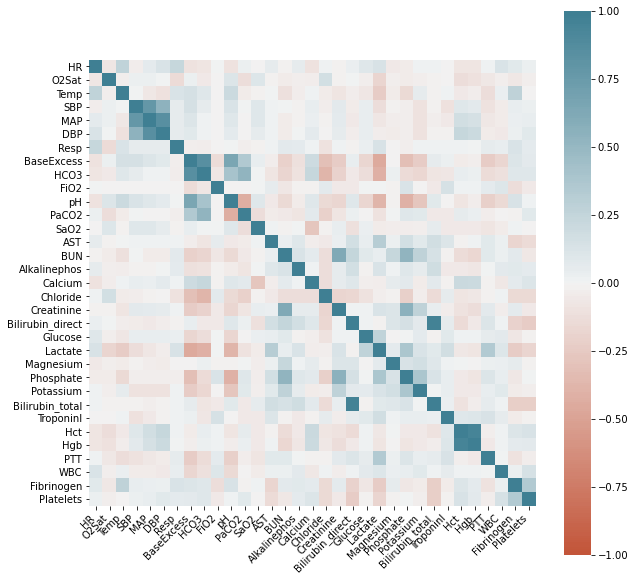

In [16]:
plot_correlation_heatmap(df_train, Globals.Fcols)


Some expected correlations here (eg. kidney indicators, pH/carbonate, biliruben, BPs). Could probably do some dimensionality reduction/embedding and maintatin a lot of the variability.

# Filtering Data  
Since we're interested in predicting patients that will have sepsis in 4 hours' time we will do some filtering of the data set as follows:
- Remove patients that have sepsis within the first four hours (b/c not useful for seeing patient's condition leading up to 4 hours before sepsis label)  
- Remove rows after the first time the 4-hours ahead sepsis label is true (also b/c not useful for leading up to sepsis label)
- Remove the last four hours of data for patients that do not have a sepsis label at any point in the data set because we don't know whether they go on to develop sepsis after the time period for which we have data (may not be necessary if end of patient history is hospital discharge or some other event indicating sepsis risk is significantly reduced)  

Note: Filtering these rows is losing a lot of information that might be helpful for understanding the sepsis state, and could potentially help with feature engineering or other modeling approaches. However, for this example and in the interest of getting something end-to-end quickly, I'll keep things simple for now.

In [17]:
time_idx = 'hour'
label_col = Globals.Label_col
label_col_ahead = Globals.Label_col+'_next'+str(Globals.Hours_Ahead)
group_name = Globals.Patient_ID
pred_hours_ahead = Globals.Hours_Ahead

df_train = filter_rows(df_train, time_idx, label_col, label_col_ahead, group_name, pred_hours_ahead)    
df_dev =   filter_rows(df_dev,   time_idx, label_col, label_col_ahead, group_name, pred_hours_ahead)

# Missing Data

Missing Completely at Random (MCAR) - simplest case for imputation, can impute from pop distr  
Missing at Random (MAR) - can impute from observed variables  
Missing Not at Random (MNAR) - Missing value is from different distr than observed values (missingness is meaningful) 

It is well-known that clinical data is MNAR but we will use some simple imputation here for expediency (assumes MCAR) and we will include a missingness indicator.

In [14]:
missing_pct = 0.33

pct_missing_byPatient_cols = df_train.groupby(Globals.Patient_ID)[Globals.Fcols].mean().reset_index().isnull().sum()/df_train[Globals.Patient_ID].nunique()
display(Markdown('Columns missing at least {:.0%} data at the patient level and proportion missing: '.format(missing_pct)))
display(pct_missing_byPatient_cols[pct_missing_byPatient_cols>missing_pct].sort_values())


display(Markdown('There are {} columns (out of {} with varying data) that are missing values for over {:.0%} of patients'\
                 .format(pct_missing_byPatient_cols[pct_missing_byPatient_cols>missing_pct].shape[0], pct_missing_byPatient_cols.shape[0], missing_pct)
                ))


Columns missing at least 33% data at the patient level and proportion missing: 

Chloride            0.477770
HCO3                0.506255
PTT                 0.510540
pH                  0.544885
PaCO2               0.558370
FiO2                0.571415
AST                 0.658159
Bilirubin_total     0.661090
Alkalinephos        0.662602
BaseExcess          0.679932
SaO2                0.687400
Lactate             0.704225
TroponinI           0.829663
Fibrinogen          0.891987
Bilirubin_direct    0.951760
dtype: float64

There are 15 columns (out of 34 with varying data) that are missing values for over 33% of patients

### Imputation  
There are many approaches for imputation of missing data in healthcare. Some of these include:  
- Carry-forward: If we have a value for some measurement, we carry it forward until we get a new value. This approach is simple but may introduce bias
- Simple imputation: Impute with some central tendency measure (eg. mean, median, mode, etc.)   
- Iterative and Multiple Imputation: Impute measurements based on values of other measurements (eg. MICE) (Can evaluate sensitivity of model to impuation)  
- Clustering: Cluster to find similar patients to get estimates of missing measurements  
- Interpolation and Model-fitting: Fit a model to the surrounding data (eg. time series) to infer the value at the missing point.   
- Other ML-encoding approaches: eg. PPCA
- Other statistical approaches: eg. likelihood  

__Imputation plan for this example__  
1. Carry-forward for patients that have a value within their history
2. Missingness indicator for values that are missing after carry forward  
    - General notes on missing indicator: A benefit of the missing indicator is that the presence or absence of a test does give us information about a patient's condition and care. It also allows the model to know whether a value was imputed. (There's also research around indicators and fairness that is interesting). A disadvantage of the indicator is that it encodes clinician decisions rather than patient physiology. We wouldn't want an alarm system to tell a clinician that sepsis is more likely whenver they order a test that means they are already suspecting sepsis. The inidcator also increases the dimensionality of the feature space 
    - Notes on putting indicator here: There's some subtelty around when we add the missingness indicator for these ICU measurements that will vary with the value that we are imputing. For example, some values are unlikely to change hour-to-hour so a value from a previous hour would be ery likely to represent the current hour. However, carrying something forward 12 hours may or may not be realistic, especially, given the dynamic nature of many patients' in the ICU. There are many different ways we could approach giving a model information about the reliability of a measurement at a certain time but we'll keep it simple for this example.
3. Simple imputation within patient histories  
4. Simple imputation across patients

In [18]:
df_train_fill = impute_carryforward_group_simple(df_train, group_name=Globals.Patient_ID, 
                                               group_metric='median', metric='median', 
                                               fcols=Globals.Fcols)
df_dev_fill = impute_carryforward_group_simple(df_dev, group_name=Globals.Patient_ID, 
                                               group_metric='median', metric='median', 
                                               fcols=Globals.Fcols)

df_train_fill[[Globals.Patient_ID,Globals.Time_col,'Phosphate','Phosphate_fill','Phosphate_missing']].tail(50)

pname  ICULOS  Phosphate  Phosphate_fill  Phosphate_missing
1276187  p119998      43        NaN             4.1                  0
1276188  p119998      44        NaN             4.1                  0
1276189  p119998      45        NaN             4.1                  0
1303406  p119999       1        NaN             3.3                  1
1303407  p119999       2        NaN             3.3                  1
1303408  p119999       3        NaN             3.3                  1
1303409  p119999       4        NaN             3.3                  1
1303410  p119999       5        NaN             3.3                  1
1303411  p119999       6        NaN             3.3                  1
1303412  p119999       7        NaN             3.3                  1
1303413  p119999       8        NaN             3.3                  1
1303414  p119999       9        NaN             3.3                  1
1303415  p119999      10        NaN             3.3                  1
1303416  p119999      11        NaN             3.3                  1
1303417  p119999      12        NaN             3.3                  1
1303418  p119999      13        NaN             3.3                  1
1303419  p119999      14        NaN             3.3                  1
1303420  p119999      15        NaN             3.3                  1
1303421  p119999      16        NaN             3.3                  1
1494160  p120000       1        NaN             4.0                  1
1494161  p120000       2        NaN             4.0                  1
1494162  p120000       3        NaN             4.0                  1
1494163  p120000       4        NaN             4.0                  1
1494164  p120000       5        NaN             4.0                  1
1494165  p120000       6        NaN             4.0                  1
1494166  p120000       7        NaN             4.0                  1
1494167  p120000       8        NaN             4.0                  1
1494168  p120000       9        NaN             4.0                  1
1494169  p120000      10        NaN             4.0                  1
1494170  p120000      11        NaN             4.0                  1
1494171  p120000      12        NaN             4.0                  1
1494172  p120000      13        NaN             4.0                  1
1494173  p120000      14        NaN             4.0                  1
1494174  p120000      15        NaN             4.0                  1
1494175  p120000      16        NaN             4.0                  1
1494176  p120000      17        NaN             4.0                  1
1494177  p120000      18        NaN             4.0                  1
1494178  p120000      19        NaN             4.0                  1
1494179  p120000      20        4.0             4.0                  0
1494180  p120000      21        NaN             4.0                  0
1494181  p120000      22        NaN             4.0                  0
1494182  p120000      23        NaN             4.0                  0
1494183  p120000      24        NaN             4.0                  0
1494184  p120000      25        NaN             4.0                  0
1494185  p120000      26        NaN             4.0                  0
1494186  p120000      27        NaN             4.0                  0
1494187  p120000      28        NaN             4.0                  0
1494188  p120000      29        NaN             4.0                  0
1494189  p120000      30        NaN             4.0                  0
1494190  p120000      31        NaN             4.0                  0

# Time Series Plots

In [19]:
np.random.seed(0)
patients_SepsisLabel = df_train_fill.groupby(Globals.Patient_ID)[Globals.Target_col].max().reset_index()
patients_woutSepsis = patients_SepsisLabel[patients_SepsisLabel[Globals.Target_col]==0][Globals.Patient_ID].unique()

@interact
def plot_lines(pname = np.random.choice(patients_woutSepsis, 100, replace=False)):
    display(Markdown('Patient: {}, Sepsis: {}'.format(pname, 
                                                      df_train_fill[df_train_fill.pname==pname][Globals.Target_col].max())))
    f, ax = plt.subplots(6,6, figsize=(20,16), sharex=True)
    for i,fcol in enumerate(Globals.Fcols):
        sns.lineplot(x = Globals.Time_col, y = fcol, data=df_train_fill[df_train_fill.pname==pname], 
                     ax=ax[int(i/6), i%6])
        sns.lineplot(x = Globals.Time_col, y = fcol+'_fill', 
                     data=df_train_fill[df_train_fill.pname==pname], ax=ax[int(i/6), i%6], color='g', alpha=0.4)
    plt.tight_layout()
    return plt.show()


interactive(children=(Dropdown(description='pname', options=('p116197', 'p117814', 'p016554', 'p116609', 'p003…

In [20]:
np.random.seed(0)
patients_wSepsis = df_train_fill[df_train_fill[Globals.Target_col]==1][Globals.Patient_ID].unique()

@interact
def plot_lines(pname = np.random.choice(patients_wSepsis, 100, replace=False)):
    display(Markdown('Patient: {}, Sepsis: {}'.format(pname, 
                                                      df_train_fill[df_train_fill.pname==pname][Globals.Target_col].max())))
    f, ax = plt.subplots(6,6, figsize=(20,20), sharex=True)
    for i,fcol in enumerate(Globals.Fcols):
        sns.lineplot(x = Globals.Time_col, y = fcol, data=df_train_fill[df_train_fill.pname==pname], 
                     ax=ax[int(i/6), i%6])
        sns.lineplot(x = Globals.Time_col, y = fcol+'_fill', 
                     data=df_train_fill[df_train_fill.pname==pname], ax=ax[int(i/6), i%6], color='g', alpha=0.4)
    plt.tight_layout()
    return plt.show()


interactive(children=(Dropdown(description='pname', options=('p107246', 'p109332', 'p102260', 'p017854', 'p119…

# Classification
I'm showing just two classifiers here: Logistic Regression and XGBoost. I've implemented a class to wrap these classifiers to demonstrate the method (see Helpers.py). We could also use this API for a custom classifier. An interesting classifier in this case could be the sepsis clinical criteria for comparison to the ML methods. Logistic Regression is used here as a baseline model with XGB as a comparison with more capacity.

## Objective Function
In the absence of discussions with stakeholders, we'll assume equal costs for FP and FN and evaluate model performance with AUCPR and F1-score. This is not a realistic assumption, and in reality, objective function and operating point would depend on these different costs and how the model might impact care decisions. The unit of measurement will be patient-hour (eg. evaluating false alarms based on the number of times that the model is run, not per patient)

## Predict using single hour
Let's look at just using the data for the current hour to predict whether the patient will have a sepsis in 4 hours. This loses a lot of information about the patient's history and trajectory but might be an interesting baseline to start with. 

Make X and y using all patient data columns except those related to the hospital stay (Units and time columns)

In [35]:
X_cols = ['Age','Gender']
for c in df_train_fill.columns.values:
    if 'lag' in c: # this is to filter out the engineered features we're using in the next step
        continue
    if ('_fill' in c) or ('_missing' in c):
        X_cols.append(c)

X_train = df_train_fill[X_cols].values
y_train = df_train_fill[Globals.Target_col].values

X_dev = df_dev_fill[X_cols].values
y_dev = df_dev_fill[Globals.Target_col].values

pos_weight = y_train[y_train==0].size/y_train[y_train==1].size

Train logistic regression and XGBoost classifiers and look at results

### Classifier: Logistic Regression

Classification Accuracy, dev: 0.6548

Balanced Classification Accuracy, dev: 0.6587

Precision, dev: 0.002819

Recall, dev: 0.6625

F1, dev: 0.006688

Plots for dev data

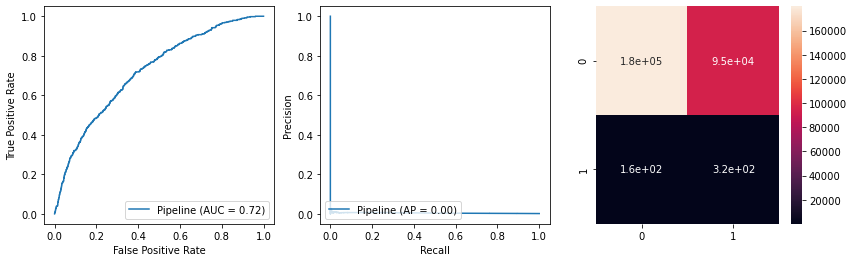

Classification Accuracy, train: 0.6507

Balanced Classification Accuracy, train: 0.6566

Precision, train: 0.002597

Recall, train: 0.6625

F1, train: 0.00615

Plots for train data

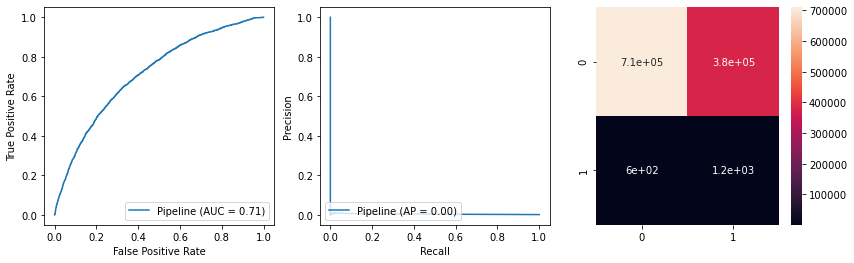

Time elapsed for model training (minutes): 2.7

### Classifier: XGBoost

/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Classification Accuracy, dev: 0.9297

Balanced Classification Accuracy, dev: 0.631

Precision, dev: 0.003935

Recall, dev: 0.3313

F1, dev: 0.01627

Plots for dev data

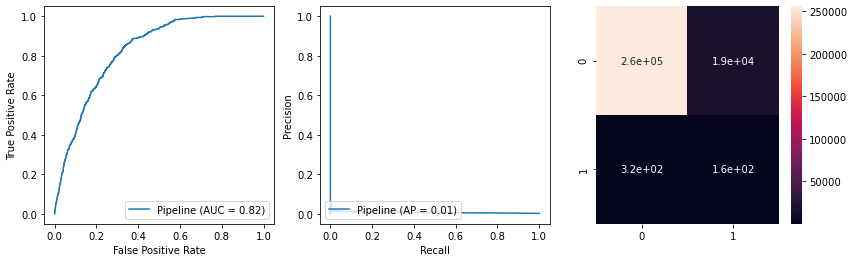

Classification Accuracy, train: 0.8698

Balanced Classification Accuracy, train: 0.923

Precision, train: 0.01184

Recall, train: 0.9764

F1, train: 0.02388

Plots for train data

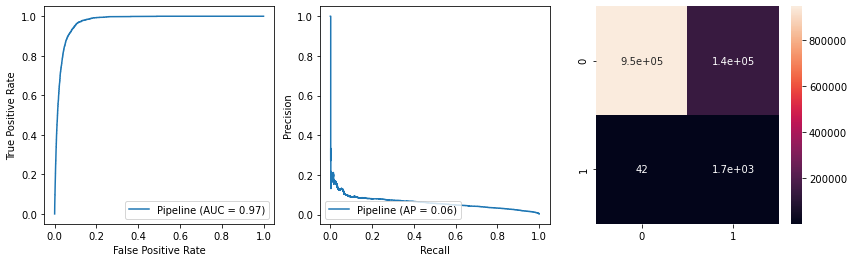

Time elapsed for model training (minutes): 3.8

In [34]:
classifiers = [
    MyLogisticRegression(myclass_weight='balanced', mymax_iter=5000),
    MyXGBClassifier(pos_weight=pos_weight, reg_lambda=10000),    # lambda for L2 regularization
    ]

starttime = time()
for classifier in classifiers:
    display(Markdown('### Classifier: {}'.format(classifier.name)))
    if classifier.needs_normalization:
        pipe = Pipeline(steps=[('transformer', Normalizer()),
                               ('classifier', classifier)])
    else:
        pipe = Pipeline(steps=[('classifier', classifier)])

    pipe.fit(X_train, y_train)
    y_dev_pred = pipe.predict(X_dev)
    y_train_pred = pipe.predict(X_train)

    show_model_scores(pipe, X_dev, y_dev, y_dev_pred, 'dev')
    show_model_scores(pipe, X_train, y_train, y_train_pred, 'train')
    
    display(Markdown('Time elapsed for model training (minutes): {:.2}'.format((time()-starttime)/60)))

So many false positives! This is common with predictions of rare events and medical alert ML systems. There's certainly a large gap between the performance of these models and where we'd like to be (high bias), and a significant gap between dev and train for XGBoost (overfitting and high variance for XGB). Overitting is a common problem for boosted decision trees. Typical approaches to reduce bias include increasing the flexibility of the model and improving the model training (eg. optimization). Typical approaches to reduce variance include getting more data and increasing regularization (and different models). I'm skipping hyperparameter tuning for now but, in general, this process can improve model performance.

## Feature Engineering
Let's add some patient history to the features to see if changes over time help make a prediction. The *Insight* sepsis prediction [13] uses lagged values and deltas of vitals, so that might be a good place to start. From looking at the time series plots for sepsis and non-sepsis patients, it looks like the vitals trends might be useful features. Therefore, I'll include vitals at 2-, 4-, and 6-hour lags as well as the deltas between those lags and the most recent value.

In [40]:
lags = [2,4,6] # lags in hours that we are using for additional vitals features
df_train_fill = add_hist_features(df_train_fill, lags,  Globals.Vitals_cols, Globals.Patient_ID)
df_dev_fill = add_hist_features(df_dev_fill, lags,  Globals.Vitals_cols, Globals.Patient_ID)

df_train_fill[[Globals.Patient_ID, Globals.Time_col, 'HR', 'HR_fill', 
               'HR_fill_lag2', 'HR_fill_lag4', 'HR_fill_lag6',
               'HR_fill_lag2_delta', 'HR_fill_lag4_delta', 'HR_fill_lag6_delta'
              ]]


pname  ICULOS     HR  HR_fill  HR_fill_lag2  HR_fill_lag4  \
401726   p000001       1    NaN    104.0           NaN           NaN   
401727   p000001       2   97.0     97.0           NaN           NaN   
401728   p000001       3   89.0     89.0         104.0           NaN   
401729   p000001       4   90.0     90.0          97.0           NaN   
401730   p000001       5  103.0    103.0          89.0         104.0   
...          ...     ...    ...      ...           ...           ...   
1494186  p120000      27   74.0     74.0          74.0          78.0   
1494187  p120000      28   82.0     82.0          72.0          76.0   
1494188  p120000      29   86.0     86.0          74.0          74.0   
1494189  p120000      30   76.0     76.0          82.0          72.0   
1494190  p120000      31   80.0     80.0          86.0          74.0   

         HR_fill_lag6  HR_fill_lag2_delta  HR_fill_lag4_delta  \
401726            NaN                 NaN                 NaN   
401727            NaN                 NaN                 NaN   
401728            NaN               -15.0                 NaN   
401729            NaN                -7.0                 NaN   
401730            NaN                14.0                -1.0   
...               ...                 ...                 ...   
1494186          82.0                 0.0                -4.0   
1494187          78.0                10.0                 6.0   
1494188          78.0                12.0                12.0   
1494189          76.0                -6.0                 4.0   
1494190          74.0                -6.0                 6.0   

         HR_fill_lag6_delta  
401726                  NaN  
401727                  NaN  
401728                  NaN  
401729                  NaN  
401730                  NaN  
...                     ...  
1494186                -8.0  
1494187                 4.0  
1494188                 8.0  
1494189                 0.0  
1494190                 6.0  

[1091946 rows x 10 columns]

These delta are quite noisy (especially with simple imputation), a smoother measure of trend might perform better

Remove rows from too early in the patient history to have lagged features (first 6 hours)

In [41]:
df_train_fill_wLags = df_train_fill[df_train_fill['HR_fill_lag6'].notnull()].copy()
df_dev_fill_wLags = df_dev_fill[df_dev_fill['HR_fill_lag6'].notnull()].copy()

## Predict using lagged vitals

Make X and y with lagged features

In [42]:
X_cols = ['Age','Gender']
for c in df_train_fill.columns.values:
    if ('_fill' in c) or ('_missing' in c):
        X_cols.append(c)

X_train = df_train_fill_wLags[X_cols].values
y_train = df_train_fill_wLags[Globals.Target_col].values

X_dev = df_dev_fill_wLags[X_cols].values
y_dev = df_dev_fill_wLags[Globals.Target_col].values

pos_weight = y_train[y_train==0].size/y_train[y_train==1].size

Train logistic regression and XGBoost classifiers and look at results

## Classifier: Logistic Regression

Classification Accuracy, dev: 0.6676

Balanced Classification Accuracy, dev: 0.6568

Precision, dev: 0.003068

Recall, dev: 0.646

F1, dev: 0.007363

Plots for dev data

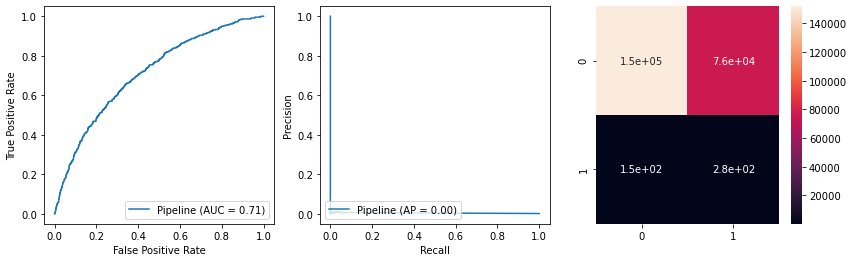

Classification Accuracy, train: 0.6595

Balanced Classification Accuracy, train: 0.6609

Precision, train: 0.00284

Recall, train: 0.6622

F1, train: 0.006757

Plots for train data

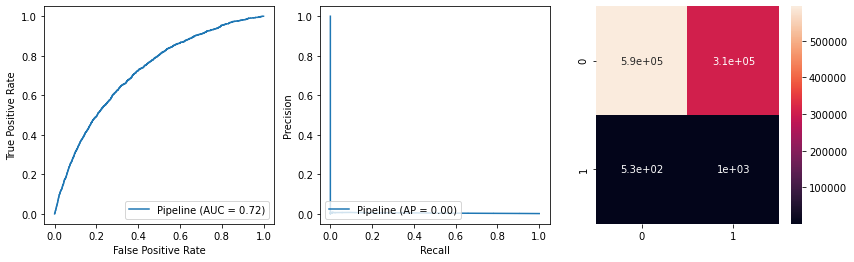

Time elapsed for model training (minutes): 3.9

## Classifier: XGBoost

/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:11:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Classification Accuracy, dev: 0.924

Balanced Classification Accuracy, dev: 0.643

Precision, dev: 0.004513

Recall, dev: 0.3609

F1, dev: 0.0178

Plots for dev data

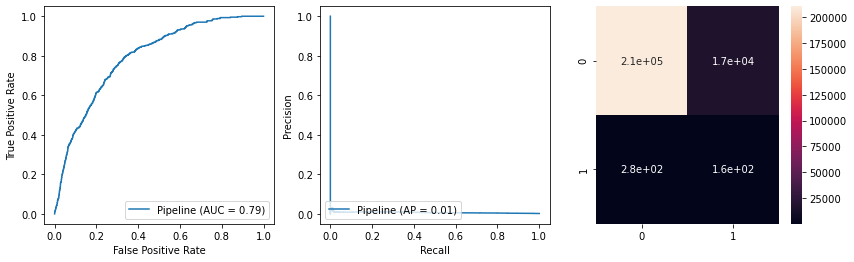

Classification Accuracy, train: 0.9086

Balanced Classification Accuracy, train: 0.9514

Precision, train: 0.01857

Recall, train: 0.9943

F1, train: 0.03665

Plots for train data

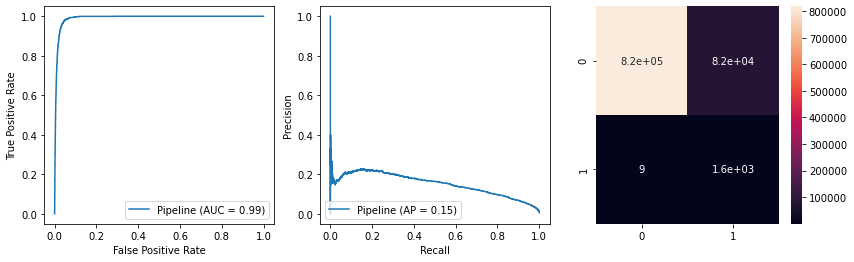

Time elapsed for model training (minutes): 5.4

In [44]:
classifiers = [
    MyLogisticRegression(myclass_weight='balanced', mymax_iter=5000),
    MyXGBClassifier(pos_weight=pos_weight, reg_lambda=10000),
    ]

starttime = time()
for classifier in classifiers:
    display(Markdown('## Classifier: {}'.format(classifier.name)))
    if classifier.needs_normalization:
        pipe = Pipeline(steps=[('transformer', Normalizer()),
                               ('classifier', classifier)])
    else:
        pipe = Pipeline(steps=[('classifier', classifier)])

    pipe.fit(X_train, y_train)
    y_dev_pred = pipe.predict(X_dev)
    y_train_pred = pipe.predict(X_train)

    show_model_scores(pipe, X_dev, y_dev, y_dev_pred, 'dev')
    show_model_scores(pipe, X_train, y_train, y_train_pred, 'train')
    
    display(Markdown('Time elapsed for model training (minutes): {:.2}'.format((time()-starttime)/60)))

It doesn't look like these lagged features have helped much, except it looks like we're overfitting even more with XGB. Both of these classifiers allow us to inspect feature contributions so that could be an interesting next step to see what the models are learning. It would also be interesting to inspect the types of cases that the models are mis-classifying.

# Some Additional Thoughts

- Looking at results in this notebook is a nice way to get an initital sense of the use case, but in my work on real projects, I keep a more rigorous log of experiments performed and the associated results
- With so few positive cases, anomaly detection might be an interesting approach
- There is a lot more feature engineering that can be done here  

# References (Links)
Data Dictionary  
[1] https://www.uofmhealth.org/health-library/hw2343#:~:text=Test%20Overview,carbon%20dioxide%20from%20the%20blood  
[2] https://emupdates.com/spo2-sao2-pao2/  
[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4267040/    
[4] https://www.mayoclinic.org/tests-procedures/blood-urea-nitrogen/about/pac-20384821  
[5] https://www.webmd.com/a-to-z-guides/what-is-a-lactic-acid-blood-test  
[6] https://medlineplus.gov/lab-tests/magnesium-blood-test/  
[7] https://medlineplus.gov/lab-tests/phosphate-in-blood/  
[8] https://www.webmd.com/a-to-z-guides/bilirubin-test#2  
[9] https://labtestsonline.org/tests/troponin  
[10] https://www.mayoclinic.org/tests-procedures/hematocrit/about/pac-20384728
[11] https://medlineplus.gov/lab-tests/partial-thromboplastin-time-ptt-test/  
[12] https://medlineplus.gov/ency/article/003650.htm   

*Insight* Sepsis prediction  
[13] https://bmjopen.bmj.com/content/8/1/e017833